<div align="center" class="alert alert-warning" role="alert">
    <h1>Жёлтое такси в Нью-Йорке</h1>
    <h3>прогнозирование временных рядов на карте</h3>
    <h1><small class="text-muted">
        финальный проект по специализации "Машинное обучение и анализ данных"
        <br>
        https://www.coursera.org/specializations/machine-learning-data-analysis
    </small></h1>
</div>

<div align="right" class="alert alert-warning" role="alert">
    <h3>Евгения Хомякова, 2020/06</h3>
</div>

## Описание проекта
Нью-Йоркская комиссия по такси и лимузинам ([TLC](https://www1.nyc.gov/site/tlc/index.page)) предоставляет подробные анонимизированные данные о поездках клиентов с 2009 года. Машины, выкрашенные жёлтым, имеют право брать пассажиров на улицах в любом из пяти [боро](https://ru.wikipedia.org/wiki/Боро_(Нью-Йорк)) города.

Эти данные разбиты на csv-файлы по месяцам. В каждом из файлов содержится подробная [информация о поездках](https://data.cityofnewyork.us/api/views/biws-g3hs/files/eb3ccc47-317f-4b2a-8f49-5a684b0b1ecc?download=true&filename=data_dictionary_trip_records_yellow.pdf). С подробным устройством файлом ознакомимся ниже.

*Каждый файл содержит миллионы строк, к сожалению, обрабатывать весь объем данных за 2009-2019 годы мне не позволяют мощности компьтера.*

**ЗАДАЧА ПРОЕКТА: Используя исторические данные о поездках желтых такси, необходимо построить прогнозирующие модели для все зон такси Нью-Йорка.**

<div align="center" class="alert alert-warning" role="alert">
    <h1> Предобработка данных</h1>
</div>

In [1]:
import urllib.request

import pandas as pd
import numpy as np
from datetime import datetime

import geopandas as gpd
import matplotlib.pyplot as plt

from shapely.geometry import Point

hour = pd.DateOffset(hours=1)

## 1. Загрузка данных с сайта TLC

###  1.1 Trip data
Данные о поездках желтого такси, сгруппированные по месяцам каждого года, скачиваю [отсюда.](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page)

Данных очень много, но чтобы увидеть годовую сезонность, необходимо взять данные минимум за два года. Таким образом будем анализировать данные за 2016-2018 годы.

#### Интересный факт

Как выглядит файл с записями о поездках до 2016/07:

In [2]:
tripdata_old = pd.read_csv('NYC_TAXI_data/2016/tripdata.2016-06.csv', nrows=4)
tripdata_old

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2016-06-09 21:06:36,2016-06-09 21:13:08,2,0.79,-73.983360,40.760937,1,N,-73.977463,40.753979,2,6.0,0.5,0.5,0.00,0,0.3,7.30
1,2,2016-06-09 21:06:36,2016-06-09 21:35:11,1,5.22,-73.981720,40.736668,1,N,-73.981636,40.670242,1,22.0,0.5,0.5,4.00,0,0.3,27.30
2,2,2016-06-09 21:06:36,2016-06-09 21:13:10,1,1.26,-73.994316,40.751072,1,N,-74.004234,40.742168,1,6.5,0.5,0.5,1.56,0,0.3,9.36
3,2,2016-06-09 21:06:36,2016-06-09 21:36:10,1,7.39,-73.982361,40.773891,1,N,-73.929466,40.851540,1,26.0,0.5,0.5,1.00,0,0.3,28.30


Как выглядит файл с записями о поездках начиная с 2016/07 (еще и поехали столбцы куда-то):

In [3]:
tripdata_new = pd.read_csv('NYC_TAXI_data/2016/tripdata.2016-07.csv', nrows=4)
tripdata_new

VendorID  tpep_pickup_datetime  \
1 2016-07-10 06:56:05  2016-07-10 06:59:53                     1   
2 2016-07-10 10:50:18  2016-07-10 10:55:21                     5   
  2016-07-10 10:50:18  2016-07-10 11:08:38                     1   
1 2016-07-10 10:50:19  2016-07-10 10:55:14                     1   

                       tpep_dropoff_datetime  passenger_count trip_distance  \
1 2016-07-10 06:56:05                   0.50                1             N   
2 2016-07-10 10:50:18                   1.34                1             N   
  2016-07-10 10:50:18                   9.48                1             N   
1 2016-07-10 10:50:19                   1.00                1             N   

                       RatecodeID  store_and_fwd_flag  PULocationID  \
1 2016-07-10 06:56:05         263                 236             1   
2 2016-07-10 10:50:18         142                 163             1   
  2016-07-10 10:50:18          74                  66             1   
1 2016-07-10 10:50:19         264                 264             2   

                       DOLocationID  payment_type  fare_amount  extra  \
1 2016-07-10 06:56:05           4.5             1          0.5   2.70   
2 2016-07-10 10:50:18           6.0             0          0.5   1.36   
  2016-07-10 10:50:18          27.0             0          0.5   0.00   
1 2016-07-10 10:50:19           5.5             0          0.5   0.00   

                       mta_tax  tip_amount  tolls_amount  \
1 2016-07-10 06:56:05        0         0.3          9.00   
2 2016-07-10 10:50:18        0         0.3          8.16   
  2016-07-10 10:50:18        0         0.3         27.80   
1 2016-07-10 10:50:19        0         0.3          6.30   

                       improvement_surcharge  total_amount  
1 2016-07-10 06:56:05                    NaN           NaN  
2 2016-07-10 10:50:18                    NaN           NaN  
  2016-07-10 10:50:18                    NaN           NaN  
1 2016-07-10 10:50:19                    NaN           NaN

Начиная c 2016/07 формат данных в файлах меняется - широта и долгота поездки больше не указывается, вместо этого есть две колонки `'PULocationID'` и `'DOLocationID'`, которые означают номера географических зон, откуда поездка началась и где закончилась. Посмотрим на эти зоны. 

Однако, с файлами после 2017-01 все нормально уже в плане индексов и столбцов:

In [4]:
tripdata_2017 = pd.read_csv('NYC_TAXI_data/2017/tripdata.2017-07.csv', nrows=4)
tripdata_2017

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2017-07-01 00:06:25,2017-07-01 00:10:50,1,1.2,1,N,249,90,1,5.5,0.5,0.5,1.35,0.00,0.3,8.15
1,1,2017-07-01 00:20:04,2017-07-01 00:21:38,2,0.2,1,N,249,158,2,3.0,0.5,0.5,0.00,0.00,0.3,4.30
2,1,2017-07-01 00:44:10,2017-07-01 00:59:29,1,4.3,1,N,100,45,1,15.5,0.5,0.5,3.35,0.00,0.3,20.15
3,1,2017-07-01 00:07:33,2017-07-01 00:31:30,1,8.3,1,N,138,162,1,27.0,0.5,0.5,6.80,5.76,0.3,40.86


###  1.2 Taxi zones
С сайта TLC скачиваем [shapefile](https://s3.amazonaws.com/nyc-tlc/misc/taxi_zones.zip) c координатами зон, на которые поделен город. [Здесь](https://mygeodata.cloud/converter/shp-to-latlong) этот файл переформатируем в geojson с координатами долготы/широты каждой зоны. Посмотрим на него:

In [5]:
regions = gpd.read_file('NYC_TAXI_data/other_data/taxi_zones.geojson').loc[:,['zone', 'OBJECTID', 'borough','geometry']]
regions.columns = ['zone_name', 'zone_id', 'borough','geometry']
regions.head()

,zone_name,zone_id,borough,geometry
0,Newark Airport,1,EWR,"POLYGON ((-74.18445 40.69500, -74.18449 40.695..."
1,Jamaica Bay,2,Queens,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ..."
2,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((-73.84793 40.87134, -73.84725 40.870..."
3,Alphabet City,4,Manhattan,"POLYGON ((-73.97177 40.72582, -73.97179 40.725..."
4,Arden Heights,5,Staten Island,"POLYGON ((-74.17422 40.56257, -74.17349 40.562..."


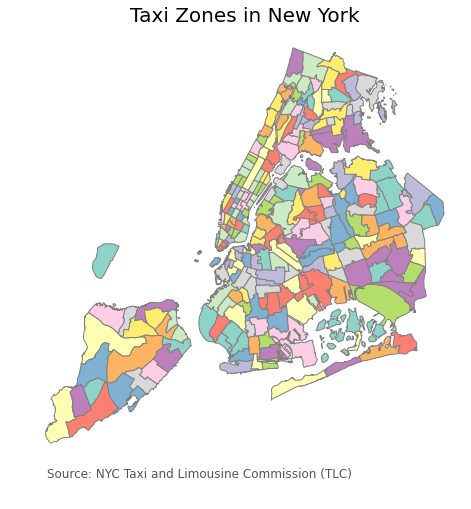

In [6]:
fig, ax = plt.subplots(1, figsize=(8, 8))
regions.to_crs({'proj': 'merc'}).plot(column='zone_id', cmap='Set3', ax=ax, edgecolor='0.5')
ax.axis('off')
ax.set_title('Taxi Zones in New York', fontdict={'fontsize': '20', 'fontweight' : '3'})
ax.annotate('Source: NYC Taxi and Limousine Commission (TLC)',
            xy=(0.1, .08), 
            xycoords='figure fraction', 
            horizontalalignment='left',
            verticalalignment='top',
            fontsize=12, color='#555555')
plt.savefig('exp/zones_gdf.png')
plt.show()

In [7]:
regions_names = regions[['zone_id', 'zone_name', 'borough']].copy()
regions_names['zone_id'] = regions['zone_id'].astype(str)

In [8]:
regions_names.head()

,zone_id,zone_name,borough
0,1,Newark Airport,EWR
1,2,Jamaica Bay,Queens
2,3,Allerton/Pelham Gardens,Bronx
3,4,Alphabet City,Manhattan
4,5,Arden Heights,Staten Island


In [9]:
# квадрат, в который вписан Нью-Йорк
NY_SQUARE = np.array([[-74.25559,-73.70001], # диапазон долготы / longitude
                      [40.49612, 40.91553]]) # диапазон широты / latitude

## 2. Предобработка данных
На этот этапе нужно привести все таблицы с данными в единый вид, почистить данные от ошибок и аномалий, получить собственно временные ряды, которые будем анализировать и предсказывать в дальнейшем. Временной ряд - количество поездок и данного региона в каждый час времени.

    ### Значения столбцов
    * Payment_type: A numeric code signifying how the passenger paid for the trip: 
        * 1= Credit card
        * 2= Cash
        * 3= No charge
        * 4= Dispute
        * 5= Unknown
        * 6= Voided trip
### 2.1 Данные до 2016/07
Все поездки до 2016/07 нужно разметить по регионам и боро (соотнося широту/долготу посадки/высадки с данными из файла выше).

In [10]:
# какие столбцы из сырых данных до 2016/07 использую
usecols=[1,2,3,4,5,6,9,10,11,17]
# переименую их
column_names = ['pickup_datetime',# 1
                'dropoff_datetime',# 2
                'passenger_count',# 3
                'trip_distance',# 4
                'pickup_longitude',# 5
                'pickup_latitude',# 6
                'dropoff_longitude',# 9
                'dropoff_latitude',# 10
                'payment_type',# 11
                'total_cost']# 17
dtype={'passenger_count': int,
       'trip_distance': float,
       'pickup_longitude': float,
       'pickup_latitude': float,
       'dropoff_longitude': float,
       'dropoff_latitude': float,
       'total_cost':float
      }

In [11]:
%%time
for year in [2016]:
    print(f'year {year}; {datetime.now().strftime("%H:%M:%S")}')
    for month in range(1,7):
        print(f'month {month}; {datetime.now().strftime("%H:%M:%S")}')
        
        tripdatafile = f'NYC_TAXI_data/{year}/tripdata.{year}-{month:0>2d}.csv'
        df = pd.read_csv(tripdatafile, sep=',', header=0, usecols=usecols, names=column_names,
                         parse_dates = [0,1], dtype=dtype)
        
        ##############################
        
        ### ФИЛЬТРУЕМ ОТ ОШИБОК И АНОМАЛИЙ ###
        df = df[(df.loc[:,'dropoff_datetime'] != df.loc[:,'pickup_datetime']) & # с нулевой длительностью
                (df.loc[:,'passenger_count'] > 0) & # с нулевым количеством пассажиров
                (df.loc[:,'trip_distance'] > 0) & # c нулевым расстоянием по счётчику
                (df.loc[:,'pickup_longitude'] >= NY_SQUARE[0][0]) &
                (df.loc[:,'pickup_longitude'] <= NY_SQUARE[0][1]) & # с долготой начала поездки вне Нью-Йорка
                (df.loc[:,'pickup_latitude'] >= NY_SQUARE[1][0]) &
                (df.loc[:,'pickup_latitude'] <= NY_SQUARE[1][1]) & # с широтой начала поездки вне Нью-Йорка
                (df['pickup_datetime'].dt.year == year) & # только нужный год (попадается!)
                (df['pickup_datetime'].dt.month == month) # только нужный месяц
               ]
        
        ##############################
        
        ### ДОБАВИМ НОВЫЕ СТОЛБЦЫ И ОТФОРМАТИРУЕМ СТАРЫЕ###
        # добавим длительность поездки
        df['trip_duration'] = (df['dropoff_datetime'] - df['pickup_datetime']).apply(lambda x: x.total_seconds())
        # отбросим минуты и секунды времени начала и конца поездки
        df['pickup_datetime'] = pd.to_datetime(df.loc[:,'pickup_datetime']).dt.floor('H')
        # преобразуем колонку payment_type
        if df['payment_type'].dtype == object:
            df['payment_type'] = [x[:3].lower() for x in df['payment_type'].values]
            df['payment_type'] = df['payment_type'].map({'cre':1, 'cas': 2, 'no ':3, 'dis':4, 'unk': 5, 'voi':6})
        
        ##############################
        
        ### РАЗМЕЧАЕМ ПОЕЗДКИ ПО ЗОНАМ И БОРО ###
        #  создаем столбец координат точек посадки/высадки
        df['PUpoint'] = df.apply(lambda row: Point(row['pickup_longitude'], row['pickup_latitude']), axis=1)
        df['DOpoint'] = df.apply(lambda row: Point(row['dropoff_longitude'], row['dropoff_latitude']), axis=1)
        # удалим ненужные колонки
        df = df.drop(['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude', 'dropoff_datetime'], axis=1)
        
        ## PICK UP
        df = gpd.GeoDataFrame(df, geometry='PUpoint')
        df.crs = 'epsg:4326'
        df = gpd.sjoin(df, regions, how="inner", op='intersects').drop('index_right', axis=1)
        df = df.rename(columns={'zone_name':'PU_zone_name',
                                'zone_id':'PU_zone_id',
                                'borough':'PU_borough'})
        
        ## DROP OFF
        df = gpd.GeoDataFrame(df, geometry='DOpoint')
        df.crs = 'epsg:4326'
        df = gpd.sjoin(df, regions, how="inner", op='intersects').drop('index_right', axis=1)
        df = df.rename(columns={'zone_name':'DO_zone_name',
                                'zone_id':'DO_zone_id',
                                'borough':'DO_borough'})
        
        # переставим колоку с временем на первое место, заодно удалим ненужные колонки
        df = df[['pickup_datetime', 'passenger_count', 'trip_distance',
                 'payment_type', 'total_cost', 'trip_duration',
                 'PU_zone_name', 'PU_zone_id', 'PU_borough',
                 'DO_zone_name', 'DO_zone_id', 'DO_borough'
                ]]
        ##############################
        
        df = df.sort_values('pickup_datetime')
        df = df.reset_index(drop=True)
        
        df.to_csv(f'NYC_TAXI_marked_data/marked_data_{year}-{month}.csv', index=False)
        print(f'month {month} DONE; {datetime.now().strftime("%H:%M:%S")}')

year 2016; 11:14:37
month 1; 11:14:37
month 1 DONE; 12:44:52
month 2; 12:44:52
month 2 DONE; 14:17:25
month 3; 14:17:25
month 3 DONE; 15:59:09
month 4; 15:59:09
month 4 DONE; 17:39:35
month 5; 17:39:35
month 5 DONE; 19:20:10
month 6; 19:20:10
month 6 DONE; 20:56:21
Wall time: 9h 41min 44s


### 2.2 Данные  после 2016/07
Здесь все уже размечено, надо только привести к единому виду таблицы и почистить от аномалий.

In [12]:
# какие столбцы из сырых данных после 2016/07 использую
usecols=[1,2,3,4,5,7,8,9,16]      
column_names = ['pickup_datetime',# 1
                'dropoff_datetime',# 2
                'passenger_count',# 3
                'trip_distance',# 4
                'ratecodeID', #5
                'PU_zone_id', #7
                'DO_zone_id', #8
                'payment_type', #9
                'total_cost'] #16
dtype = {'passenger_count': int,
          'trip_distance': float,
          'PULocationID':int,
          'DOLocationID':int,
          'ratecodeID':int,
          'payment_type': int,
          'total_cost':float}

In [13]:
all_regions = regions['zone_id'].values
regions_names['zone_id'] = regions['zone_id'].astype(int)

In [16]:
%%time
for year in [2016,2017,2018]:
    print(f'year {year}; {datetime.now().strftime("%H:%M:%S")}')
    first_month = 1
    last_month = 12
    if year == 2016:
        first_month = 7
    for month in range(first_month,last_month+1):
        print(f'month {month}; {datetime.now().strftime("%H:%M:%S")}')
        tripdatafile = f'NYC_TAXI_data/{year}/tripdata.{year}-{month:0>2d}.csv'
        if year == 2016:
            # немного танцев с бубном, потому что криво читаются файлы 2016 года
            df = pd.read_csv(tripdatafile, sep=',')
            df = df.reset_index().iloc[:,usecols]
            df.columns = column_names
            df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
            df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])
        else:
            df = pd.read_csv(tripdatafile, sep=',', header=0,
                             usecols=usecols, names=column_names,
                             dtype=dtype, parse_dates=[0,1])

        ##############################
        
        ### ФИЛЬТРУЕМ ОТ ОШИБОК И АНОМАЛИЙ ###
        df = df[(df.loc[:,'dropoff_datetime'] != df.loc[:,'pickup_datetime']) & # с нулевой длительностью
                (df.loc[:,'passenger_count'] > 0.0) & # с нулевым количеством пассажиров
                (df.loc[:,'trip_distance'] > 0.0) & # c нулевым расстоянием по счётчику
                (df['pickup_datetime'].dt.year == year) & # только нужный год (попадается!)
                (df['pickup_datetime'].dt.month == month) # только нужный месяц
               ]
        ##############################
        
        ### ДОБАВИМ НОВЫЕ СТОЛБЦЫ И ОТФОРМАТИРУЕМ СТАРЫЕ###
        # добавим длительность поездки
        df['trip_duration'] = (df['dropoff_datetime'] - df['pickup_datetime']).apply(lambda x: x.total_seconds())
        # отбросим минуты и секунды времени начала и конца поездки
        df['pickup_datetime'] = pd.to_datetime(df.loc[:,'pickup_datetime']).dt.floor('H')
        # добавим названия регионов и названия боро
        df = df.merge(regions_names.rename(columns={'zone_id':'PU_zone_id',
                                       'zone_name':'PU_zone_name',
                                       'borough':'PU_borough'}), how='left')
        df = df.merge(regions_names.rename(columns={'zone_id':'DO_zone_id',
                                       'zone_name':'DO_zone_name',
                                       'borough':'DO_borough'}), how='left')
        # переставим колонки
        df = df[['pickup_datetime', 'passenger_count', 'trip_distance',
                 'payment_type', 'total_cost', 'trip_duration',
                 'PU_zone_name', 'PU_zone_id', 'PU_borough',
                 'DO_zone_name', 'DO_zone_id', 'DO_borough']]
        ##############################
        df = df.sort_values('pickup_datetime')
        df = df.reset_index(drop=True)
        df.to_csv(f'NYC_TAXI_marked_data/marked_data_{year}-{month}.csv', index=False)
        print(f'month {month} DONE; {datetime.now().strftime("%H:%M:%S")}')

year 2016; 21:01:29
month 7; 21:01:29
month 7 DONE; 21:05:17
month 8; 21:05:17
month 8 DONE; 21:08:57
month 9; 21:08:57
month 9 DONE; 21:12:39
month 10; 21:12:39
month 10 DONE; 21:16:34
month 11; 21:16:34
month 11 DONE; 21:20:12
month 12; 21:20:12
month 12 DONE; 21:23:57
year 2017; 21:23:57
month 1; 21:23:57
month 1 DONE; 21:27:11
month 2; 21:27:11
month 2 DONE; 21:30:15
month 3; 21:30:15
month 3 DONE; 21:33:50
month 4; 21:33:50
month 4 DONE; 21:37:08
month 5; 21:37:08
month 5 DONE; 21:40:27
month 6; 21:40:27
month 6 DONE; 21:43:44
month 7; 21:43:44
month 7 DONE; 21:47:19
month 8; 21:47:19
month 8 DONE; 21:50:10
month 9; 21:50:10
month 9 DONE; 21:53:09
month 10; 21:53:09
month 10 DONE; 21:56:23
month 11; 21:56:23
month 11 DONE; 21:59:28
month 12; 21:59:28
month 12 DONE; 22:02:37
year 2018; 22:02:37
month 1; 22:02:37
month 1 DONE; 22:05:30
month 2; 22:05:30
month 2 DONE; 22:08:26
month 3; 22:08:26
month 3 DONE; 22:12:20
month 4; 22:12:20
month 4 DONE; 22:15:23
month 5; 22:15:23
month 5 

Вот такие получаются почищенные и размеченные по регионам данные о поездках:

In [17]:
marked_data_example = pd.read_csv(f'NYC_TAXI_marked_data/marked_data_2018-1.csv',
                                  parse_dates=['pickup_datetime'], nrows=5)
marked_data_example

,pickup_datetime,passenger_count,trip_distance,payment_type,total_cost,trip_duration,PU_zone_name,PU_zone_id,PU_borough,DO_zone_name,DO_zone_id,DO_borough
0,2018-01-01,1,0.50,2,5.80,198.0,Central Harlem,41,Manhattan,Bloomingdale,24,Manhattan
1,2018-01-01,2,1.30,1,12.05,577.0,East Village,79,Manhattan,West Village,249,Manhattan
2,2018-01-01,1,4.40,2,21.80,1749.0,Clinton East,48,Manhattan,World Trade Center,261,Manhattan
3,2018-01-01,1,7.40,1,30.30,1689.0,Garment District,100,Manhattan,Central Harlem North,42,Manhattan
4,2018-01-01,1,0.84,1,11.16,726.0,Midtown Center,161,Manhattan,UN/Turtle Bay South,233,Manhattan


### 2.3 Агрегация данных

In [19]:
%%time
pu_aggregated_data = [] # это будут собственно временные ряды, которые хотим прогнозировать (число посадок в разных зонах)

first_month = 1
last_month = 12

for year in [2016, 2017, 2018]:
    print(f'year {year}; {datetime.now().strftime("%H:%M:%S")}')
    
    for month in range(first_month,last_month+1):
        print(f'month {month}; {datetime.now().strftime("%H:%M:%S")}')
        
        marked_data = pd.read_csv(f'NYC_TAXI_marked_data/marked_data_{year}-{month}.csv',
                                  parse_dates=['pickup_datetime'])
        marked_data['count'] = 1 # вспомогательный столбец
    
        if month == 12:
            all_datetimes = pd.date_range(datetime(year,12,1,0),datetime(year,12,31,23),freq='H')
        else:
            all_datetimes = pd.date_range(datetime(year,month,1,0),datetime(year,month+1,1,0)-1*hour,freq='H')
        
        all_datetimes = pd.DataFrame(all_datetimes, columns=['pickup_datetime'])
        
        # агрегация по dt и PU_zone_id
        pu_agg_data = marked_data.pivot_table('count',
                                              index = 'pickup_datetime',
                                              columns = 'PU_zone_id',
                                              aggfunc='count').fillna(0).reset_index()
        
        # добавление нулевых строк
        pu_agg_data = pu_agg_data.merge(all_datetimes, how='outer').sort_values('pickup_datetime').fillna(0).reset_index(drop=True)
        
        pu_aggregated_data.append(pu_agg_data)
        
pu_aggregated_data = pd.concat(pu_aggregated_data, axis=0,sort=True).set_index('pickup_datetime').sort_index(axis=1).fillna(0)


#если откуда-то никого не забрали никогда, то добавить нулевой столбец
for r in regions_names['zone_id'].values:
    if r not in pu_aggregated_data.columns.tolist():
        pu_aggregated_data[r] = 0


pu_aggregated_data = pu_aggregated_data.sort_index(axis=1)

pu_aggregated_data.to_csv('NYC_TAXI_aggregated_data/pu_agg_data.csv', index=True)

year 2016; 23:19:37
month 1; 23:19:37
month 2; 23:19:56
month 3; 23:20:15
month 4; 23:20:36
month 5; 23:20:55
month 6; 23:21:15
month 7; 23:21:33
month 8; 23:21:51
month 9; 23:22:09
month 10; 23:22:27
month 11; 23:22:46
month 12; 23:23:03
year 2017; 23:23:21
month 1; 23:23:21
month 2; 23:23:38
month 3; 23:23:54
month 4; 23:24:12
month 5; 23:24:30
month 6; 23:25:08
month 7; 23:25:25
month 8; 23:25:40
month 9; 23:25:55
month 10; 23:26:10
month 11; 23:26:27
month 12; 23:26:43
year 2018; 23:27:00
month 1; 23:27:00
month 2; 23:27:15
month 3; 23:27:30
month 4; 23:27:46
month 5; 23:28:03
month 6; 23:28:18
month 7; 23:28:33
month 8; 23:28:47
month 9; 23:29:00
month 10; 23:29:14
month 11; 23:29:29
month 12; 23:29:43
Wall time: 10min 27s


In [20]:
aggregated_data = pd.read_csv('NYC_TAXI_aggregated_data/pu_agg_data.csv', index_col=0)

In [21]:
aggregated_data.head(10)

,1,2,3,4,5,6,7,8,9,10,...,256,257,258,259,260,261,262,263,264,265
pickup_datetime,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,0.0,0.0,0.0,153.0,0.0,0.0,112.0,1.0,0.0,0.0,...,122.0,3.0,0.0,0.0,26.0,97.0,340.0,723.0,0.0,0.0
2016-01-01 01:00:00,0.0,0.0,1.0,218.0,0.0,0.0,277.0,0.0,0.0,1.0,...,232.0,8.0,2.0,1.0,52.0,124.0,354.0,780.0,0.0,0.0
2016-01-01 02:00:00,0.0,0.0,1.0,196.0,0.0,0.0,382.0,0.0,0.0,1.0,...,257.0,9.0,6.0,0.0,69.0,103.0,233.0,774.0,0.0,0.0
2016-01-01 03:00:00,0.0,0.0,0.0,199.0,0.0,1.0,286.0,0.0,0.0,0.0,...,257.0,5.0,5.0,1.0,80.0,68.0,114.0,491.0,0.0,0.0
2016-01-01 04:00:00,0.0,0.0,0.0,135.0,0.0,0.0,259.0,0.0,1.0,0.0,...,173.0,3.0,5.0,1.0,58.0,44.0,70.0,306.0,0.0,0.0
2016-01-01 05:00:00,1.0,0.0,1.0,72.0,0.0,0.0,103.0,0.0,0.0,1.0,...,74.0,1.0,3.0,0.0,31.0,17.0,40.0,147.0,0.0,0.0
2016-01-01 06:00:00,0.0,0.0,0.0,39.0,0.0,0.0,93.0,0.0,0.0,0.0,...,33.0,3.0,0.0,0.0,29.0,22.0,79.0,128.0,0.0,0.0
2016-01-01 07:00:00,0.0,0.0,0.0,36.0,0.0,0.0,48.0,0.0,0.0,1.0,...,31.0,2.0,0.0,0.0,25.0,18.0,70.0,122.0,0.0,0.0
2016-01-01 08:00:00,0.0,0.0,0.0,34.0,0.0,0.0,40.0,0.0,0.0,0.0,...,20.0,0.0,1.0,0.0,23.0,21.0,78.0,103.0,0.0,0.0
